# Agentic RAG From Scratch: Building with LangGraph and Open-Source Models

In this notebook, we'll look under the hood of `create_agent` and build an agentic RAG application **from scratch** using LangGraph's low-level primitives and locally-hosted open-source models.

**Learning Objectives:**
- Understand LangGraph's core constructs: StateGraph, nodes, edges, and conditional routing
- Build a ReAct agent from scratch without high-level abstractions
- Use Ollama to run open-source models locally (gpt-oss:20b + embeddinggemma)
- Transition from `aimakerspace` utilities to the LangChain ecosystem

## Table of Contents:

- **Breakout Room #1:** LangGraph Fundamentals & Building Agents from Scratch
  - Task 1: Dependencies & Ollama Setup
  - Task 2: LangGraph Core Concepts (StateGraph, Nodes, Edges)
  - Task 3: Building a ReAct Agent from Scratch
  - Task 4: Adding Tools to Your Agent
  - Question #1 & Question #2
  - Activity #1: Implement a Custom Routing Function

- **Breakout Room #2:** Agentic RAG with Local Models
  - Task 5: Loading & Chunking with LangChain
  - Task 6: Setting up Qdrant with Local Embeddings
  - Task 7: Creating a RAG Tool
  - Task 8: Building Agentic RAG from Scratch
  - Question #3 & Question #4
  - Activity #2: Extend the Agent with Memory

---
# Breakout Room #1
## LangGraph Fundamentals & Building Agents from Scratch

## Task 1: Dependencies & Ollama Setup

Before we begin, make sure you have:

1. **Ollama installed** - Download from [ollama.com](https://ollama.com/)
2. **Ollama running** - Start with `ollama serve` in a terminal
3. **Models pulled** - Run these commands:

```bash
# Chat model for reasoning and generation (~12GB)
ollama pull gpt-oss:20b

# Embedding model for RAG (~622MB)
ollama pull embeddinggemma
```

> **Note**: If you don't have enough RAM/VRAM for `gpt-oss:20b` (requires 16GB+ VRAM or 24GB+ RAM), you can substitute with `llama3.2:3b` or another smaller model.

**📚 Documentation:**
- [Ollama Installation Guide](https://ollama.com/download)
- [gpt-oss Model Card](https://ollama.com/library/gpt-oss)
- [EmbeddingGemma Model Card](https://ollama.com/library/embeddinggemma)
- [langchain-ollama Integration](https://python.langchain.com/docs/integrations/providers/ollama/)

In [1]:
# Core imports we'll use throughout the notebook
import os
import getpass
import json
from uuid import uuid4
from typing import Annotated, TypedDict, Literal

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

In [3]:
# Set OpenAI API Key
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

In [4]:
# Optional: Set up LangSmith for tracing
# This provides powerful debugging and observability for your agents

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - The Agent Loop - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key (press Enter to skip): ") or ""

if not os.environ["LANGCHAIN_API_KEY"]:
    os.environ["LANGCHAIN_TRACING_V2"] = "false"
    print("LangSmith tracing disabled")
else:
    print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")

LangSmith tracing enabled. Project: AIE9 - The Agent Loop - eb4f6511


In [30]:
# # Verify Ollama is running and models are available
# from langchain_ollama import ChatOllama, OllamaEmbeddings

# # Test connection to Ollama
# try:
#     test_llm = ChatOllama(model="gpt-oss:20b", temperature=0)
#     test_response = test_llm.invoke("Say 'Ollama is working!' in exactly 3 words.")
#     print(f"Chat Model Test: {test_response.content}")
    
#     test_embeddings = OllamaEmbeddings(model="embeddinggemma")
#     test_vector = test_embeddings.embed_query("test")
#     print(f"Embedding Model Test: Vector dimension = {len(test_vector)}")
#     print("\nOllama is ready!")
# except Exception as e:
#     print(f"Error connecting to Ollama: {e}")
#     print("\nMake sure:")
#     print("1. Ollama is installed: https://ollama.com/")
#     print("2. Ollama is running: 'ollama serve'")
#     print("3. Models are pulled: 'ollama pull gpt-oss:20b' and 'ollama pull embeddinggemma'")

## Task 2: LangGraph Core Concepts

In Session 3, we used `create_agent` which abstracts away the complexity. Now let's understand what's happening under the hood!

### LangGraph models workflows as **graphs** with three key components:

### 1. State
A shared data structure that represents the current snapshot of your application:

```python
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]  # Conversation history
```

The `add_messages` **reducer** ensures new messages are appended (not replaced) when the state updates.

### 2. Nodes
Python functions that encode the logic of your agent:
- Receive the current state
- Perform computation or side-effects
- Return an updated state

### 3. Edges
Functions that determine which node to execute next:
- **Normal edges**: Always go to a specific node
- **Conditional edges**: Choose the next node based on state

**📚 Documentation:**
- [LangGraph Low-Level Concepts](https://langchain-ai.github.io/langgraph/concepts/low_level/)
- [LangGraph Quickstart](https://langchain-ai.github.io/langgraph/tutorials/introduction/)
- [StateGraph API Reference](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph)

In [5]:
# Let's build our first LangGraph workflow - a simple echo graph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage

# Step 1: Define the State
class SimpleState(TypedDict):
    messages: Annotated[list, add_messages]

# Step 2: Define Nodes (functions that process state)
def echo_node(state: SimpleState):
    """A simple node that echoes the last message."""
    last_message = state["messages"][-1]
    echo_response = AIMessage(content=f"You said: {last_message.content}")
    return {"messages": [echo_response]}

# Step 3: Build the Graph
echo_graph = StateGraph(SimpleState)

# Add nodes
echo_graph.add_node("echo", echo_node)

# Add edges (START -> echo -> END)
echo_graph.add_edge(START, "echo")
echo_graph.add_edge("echo", END)

# Compile the graph
echo_app = echo_graph.compile()

print("Simple echo graph created!")

Simple echo graph created!


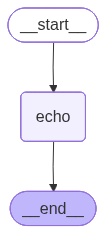

In [6]:
# Visualize the graph structure
try:
    from IPython.display import display, Image
    display(Image(echo_app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure (ASCII):")
    print(echo_app.get_graph().draw_ascii())

In [7]:
# Test the echo graph
result = echo_app.invoke({"messages": [HumanMessage(content="Hello, LangGraph!")]})

print("Conversation:")
for msg in result["messages"]:
    role = "Human" if isinstance(msg, HumanMessage) else "AI"
    print(f"  [{role}]: {msg.content}")

Conversation:
  [Human]: Hello, LangGraph!
  [AI]: You said: Hello, LangGraph!


## Task 3: Building a ReAct Agent from Scratch

Now let's build something more sophisticated: a **ReAct agent** that can:
1. **Reason** about what to do
2. **Act** by calling tools
3. **Observe** results
4. **Repeat** until done

This is exactly what `create_agent` does under the hood. Let's build it ourselves!

### The Agent Loop Architecture

```
                    ┌──────────────┐
                    │    START     │
                    └──────┬───────┘
                           │
                           ▼
                    ┌──────────────┐
             ┌─────►│    agent     │◄────────┐
             │      │  (call LLM)  │         │
             │      └──────┬───────┘         │
             │             │                 │
             │             ▼                 │
             │      ┌──────────────┐         │
             │      │ should_      │         │
             │      │ continue?    │         │
             │      └──────┬───────┘         │
             │             │                 │
             │    tool_calls?                │
             │     │           │             │
             │    YES         NO             │
             │     │           │             │
             │     ▼           ▼             │
             │ ┌────────┐  ┌───────┐         │
             │ │ tools  │  │  END  │         │
             └─┤(execute│  └───────┘         │
               │ tools) ├────────────────────┘
               └────────┘
```

**📚 Documentation:**
- [How to create a ReAct agent from scratch](https://langchain-ai.github.io/langgraph/how-tos/react-agent-from-scratch/)
- [ReAct Agent Conceptual Guide](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-agent)

In [8]:
from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

# Step 1: Define the Agent State
class AgentState(TypedDict):
    """The state of our agent - just a list of messages."""
    messages: Annotated[list[BaseMessage], add_messages]

print("AgentState defined with messages field")

c:\Users\SinhaK\AppData\Local\miniconda3\envs\agentenv312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AgentState defined with messages field


In [ ]:
# # Step 2: Initialize our local LLM with Ollama
# llm = ChatOllama(
#     model="gpt-oss:20b",
#     temperature=0,  # Deterministic for reproducibility
# )

# print(f"LLM initialized: {llm.model}")

LLM initialized: gpt-oss:20b


In [10]:
# Let's see LCEL in action with a simple example
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Create our components (each is a Runnable)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant that speaks like a pirate."),
    ("human", "{question}")
])

llm = ChatOpenAI(model="gpt-5", temperature=1)

output_parser = StrOutputParser()

# Chain them together with LCEL
pirate_chain = prompt | llm | output_parser

## Task 4: Adding Tools to Your Agent

Tools are functions that the agent can call. We use the `@tool` decorator and **bind** them to the LLM.

**📚 Documentation:**
- [LangChain Tools Conceptual Guide](https://python.langchain.com/docs/concepts/tools/)
- [@tool Decorator Reference](https://python.langchain.com/api_reference/core/tools/langchain_core.tools.convert.tool.html)
- [ToolNode Prebuilt](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode)

In [11]:
# Step 3: Define Tools
@tool
def calculate(expression: str) -> str:
    """Evaluate a mathematical expression. Use this for any math calculations.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., '2 + 2', '10 * 5')
    """
    try:
        # Using eval with restricted globals for safety
        result = eval(expression, {"__builtins__": {}}, {})
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error evaluating expression: {e}"

@tool
def get_current_time() -> str:
    """Get the current date and time. Use this when the user asks about the current time or date."""
    from datetime import datetime
    return f"The current date and time is: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

# Create our tool list
tools = [calculate, get_current_time]

# Bind tools to the LLM - this tells the LLM about available tools
llm_with_tools = llm.bind_tools(tools)

print("Tools defined and bound to LLM:")
for t in tools:
    print(f"  - {t.name}: {t.description[:50]}...")

Tools defined and bound to LLM:
  - calculate: Evaluate a mathematical expression. Use this for a...
  - get_current_time: Get the current date and time. Use this when the u...


In [12]:
# Step 4: Define the Agent Node (calls the LLM)
SYSTEM_PROMPT = """You are a helpful assistant that can perform calculations and tell the time.
Always use the available tools when appropriate.
Be concise in your responses."""

def agent_node(state: AgentState):
    """The agent node - calls the LLM with the current conversation."""
    # Prepare messages with system prompt
    messages = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]
    
    # Call the LLM
    response = llm_with_tools.invoke(messages)
    
    # Return the response to be added to state
    return {"messages": [response]}

print("Agent node defined")

Agent node defined


In [13]:
# Step 5: Define the Tool Node (executes tools)
# We can use LangGraph's prebuilt ToolNode for convenience
tool_node = ToolNode(tools)

print("Tool node created using ToolNode prebuilt")

Tool node created using ToolNode prebuilt


In [14]:
# Step 6: Define the Conditional Edge (routing logic)
def should_continue(state: AgentState) -> Literal["tools", "end"]:
    """Determine whether to call tools or end the conversation."""
    last_message = state["messages"][-1]
    
    # If the LLM made tool calls, route to tools node
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    # Otherwise, end the conversation
    return "end"

print("Conditional routing function defined")

Conditional routing function defined


In [15]:
# Step 7: Build the Graph!
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("agent", agent_node)
workflow.add_node("tools", tool_node)

# Set the entry point
workflow.add_edge(START, "agent")

# Add conditional edge from agent
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",  # If should_continue returns "tools", go to tools node
        "end": END         # If should_continue returns "end", finish
    }
)

# Add edge from tools back to agent (the loop!)
workflow.add_edge("tools", "agent")

# Compile the graph
agent = workflow.compile()

print("ReAct agent built from scratch!")

ReAct agent built from scratch!


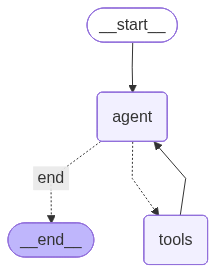

In [16]:
# Visualize our agent
try:
    from IPython.display import display, Image
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure (ASCII):")
    print(agent.get_graph().draw_ascii())

In [17]:
# Test our agent!
print("Testing our from-scratch agent:")
print("=" * 50)

response = agent.invoke({"messages": [HumanMessage(content="What is 25 * 48?")]})

print("\nConversation:")
for msg in response["messages"]:
    msg_type = type(msg).__name__
    content = msg.content if msg.content else f"[Tool calls: {msg.tool_calls}]" if hasattr(msg, 'tool_calls') and msg.tool_calls else "[No content]"
    print(f"  [{msg_type}]: {content[:200]}")

Testing our from-scratch agent:

Conversation:
  [HumanMessage]: What is 25 * 48?
  [AIMessage]: [Tool calls: [{'name': 'calculate', 'args': {'expression': '25 * 48'}, 'id': 'call_20NNCXEQDqhHFMyRDPl48B5U', 'type': 'tool_call'}]]
  [ToolMessage]: The result of 25 * 48 is 1200
  [AIMessage]: 1200


In [18]:
# Test with multiple tools
print("Testing with multiple tool calls:")
print("=" * 50)

response = agent.invoke({
    "messages": [HumanMessage(content="What time is it, and what is 100 divided by the current hour?")]
})

print("\nFinal response:")
print(response["messages"][-1].content)

Testing with multiple tool calls:

Final response:
It’s 22:24:47 on 2026-01-25. 100 divided by the current hour (22) is approximately 4.545454545454546.


In [19]:
# Stream the agent's execution to see it step by step
print("Streaming agent execution:")
print("=" * 50)

for chunk in agent.stream(
    {"messages": [HumanMessage(content="Calculate 15% of 200")]},
    stream_mode="updates"
):
    for node_name, values in chunk.items():
        print(f"\n[Node: {node_name}]")
        if "messages" in values:
            for msg in values["messages"]:
                if hasattr(msg, 'content') and msg.content:
                    print(f"  Content: {msg.content[:200]}")
                if hasattr(msg, 'tool_calls') and msg.tool_calls:
                    print(f"  Tool calls: {[tc['name'] for tc in msg.tool_calls]}")

Streaming agent execution:

[Node: agent]
  Tool calls: ['calculate']

[Node: tools]
  Content: The result of 200 * 0.15 is 30.0

[Node: agent]
  Content: 30


---
## ❓ Question #1:

In our from-scratch agent, we defined a `should_continue` function that returns either `"tools"` or `"end"`. How does this compare to how `create_agent` handles the same decision? What additional logic might `create_agent` include that we didn't implement?

##### Answer:
**should_continue** does one simple check:

Look at the last LLM message → if it contains tool_calls → go to "tools" else → "end"

So your loop decision is basically:

LLM output has tool_calls? YES → tools NO → end

That’s the same high-level decision rule used in most agent implementations.

How **create_agent** handles the same decision

**create_agent** does the same “tool_calls vs final” routing, but usually with additional logic around it. Common extras include:

***1. More robust detection***

Ensures the last message is the right type (AI/assistant message)

Handles cases like empty tool_calls, malformed tool_calls, or unexpected response formats

---

***2. Tool call validation / normalization***

Checks tool name exists

Checks required args are present and match schema

May coerce/normalize arguments (depending on stack)

---

***3. Multiple tool calls in one turn***

If the model calls 2–3 tools at once, create_agent handles executing them (possibly in sequence or batch) and appending multiple ToolMessages correctly.

---

***4. Stop conditions and safety limits***

Max iterations / max model calls (to prevent infinite loops)

Early stopping behavior (e.g., “if stuck, produce best-effort answer”)

---

***5. Error routing***

If a tool fails, the agent may return a tool error message back into the loop so the model can recover (instead of crashing the graph).




****In short: your should_continue is the minimal gate. create_agent typically adds correctness + safety + “real-world messiness handling.”****

## ❓ Question #2:

We used `ToolNode` from `langgraph.prebuilt` to execute tools. Looking at the tool execution flow, what would happen if we wanted to add logging, error handling, or rate limiting to tool execution? How would building our own tool node give us more control?

##### Answer:
*Right now you’re using:

***tool_node = ToolNode(tools)***

ToolNode is convenient, but it’s a black box: it runs tool calls and returns tool outputs. If you want production behaviors like:

1. per-tool logging (inputs/outputs/latency)

2. try/except error handling + retries

3. rate limits (per user, per tool, per minute)

4. timeouts

5. redaction of sensitive values

6. fallback logic (“if KB search fails, try a different retriever”)


…you either have to wrap each tool individually or replace ToolNode with your own node.

***How building your own tool node gives more control***

If you build your own tool node, you control the full execution loop:

Last LLM msg → read tool_calls → for each call:

1. log start time + args

2. apply rate limit / quota check

3. run tool with timeout

4. catch exceptions

5. optionally retry/backoff

6. log result/error

7. return a ToolMessage (success) or ToolMessage (error) back to state

Therefore we can do al of the below:

1. Before tool call: validate, rate limit, log

2. After tool call: log output, sanitize, cache

On failure: retry/backoff or return structured error to the model


***Concrete example of what your custom node would enable***

You could enforce rules like:

1. “KB search tool max 3 calls per user query”

2. “No tool may run longer than 5 seconds”*

---
## 🏗️ Activity #1: Implement a Custom Routing Function

Extend the agent by implementing a **custom routing function** that adds more sophisticated logic.

Ideas:
- Add a maximum iteration limit to prevent infinite loops
- Route to different nodes based on the type of tool being called
- Add a "thinking" step before tool execution

Requirements:
1. Modify the `should_continue` function or create a new one
2. Add any new nodes if needed
3. Rebuild and test the agent

**📚 Documentation:**
- [Conditional Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges)
- [How to create branches for parallel node execution](https://langchain-ai.github.io/langgraph/how-tos/branching/)

In [26]:
# --- Imports (messages, tools, graph, LLM wrapper) ---
from typing import TypedDict, List, Dict, Any, Optional, Literal
import time
import math
from datetime import datetime
from zoneinfo import ZoneInfo

from pydantic import BaseModel, Field

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph, END

# -------------------------------------------------------
# 1) Define Tools (DON'T assume they exist: we define them)
# -------------------------------------------------------

# Tool #1: calculator
class CalculateArgs(BaseModel):
    expression: str = Field(..., description="A simple math expression, e.g. '19*23'.")

@tool("calculate", args_schema=CalculateArgs)
def calculate(expression: str) -> Dict[str, Any]:
    """
    Evaluate a simple math expression.
    Use this when the user asks for arithmetic or numeric calculations.
    Input: expression (string)
    Output: result (number as string)
    """
    # Very simple evaluator: allow only safe characters (digits/operators/parentheses/decimal/space)
    allowed = set("0123456789+-*/(). %")
    if any(ch not in allowed for ch in expression):
        raise ValueError("Expression contains unsupported characters.")
    # eval is used here only for demonstration; in production you'd use a safe math parser.
    result = eval(expression, {"__builtins__": {}}, {})
    return {"expression": expression, "result": result}

# Tool #2: current time
class TimeArgs(BaseModel):
    tz: str = Field("America/Chicago", description="IANA timezone string, e.g. 'UTC' or 'America/Chicago'.")

@tool("get_current_time", args_schema=TimeArgs)
def get_current_time(tz: str = "America/Chicago") -> Dict[str, Any]:
    """
    Get the current time in a given timezone.
    Use this when the user asks for the current time 'now' in a city/timezone.
    """
    now = datetime.now(ZoneInfo(tz))
    return {"timezone": tz, "iso": now.isoformat(), "readable": now.strftime("%Y-%m-%d %H:%M:%S")}

# Tool #3: simple "wellness KB search" (toy KB for demo)
# In your real notebook, this would query your vector DB / docs store.
class KBArgs(BaseModel):
    query: str = Field(..., description="User question to search inside the wellness knowledge base.")
    top_k: int = Field(3, description="How many results to return.")

@tool("search_wellness_knowledge", args_schema=KBArgs)
def search_wellness_knowledge(query: str, top_k: int = 3) -> Dict[str, Any]:
    """
    Search a wellness knowledge base and return evidence snippets with citations.
    Use this when you need factual wellness guidance (progressive overload, deload, recovery).
    """
    # Tiny fake KB entries (replace with your real KB retrieval)
    kb = [
        {"id": "KB1", "title": "Deload Guidance", "text": "If fatigue stalls performance for ~2+ weeks, reduce volume by ~30–50% for 1 week (deload)."},
        {"id": "KB2", "title": "Progressive Overload", "text": "Add small load (2–5%) or 1 rep weekly while keeping 1–3 reps in reserve (RIR). Increase load after topping rep range."},
        {"id": "KB3", "title": "Recovery Basics", "text": "Sleep and hydration strongly influence recovery, performance, and muscle gain."},
    ]
    # Naive retrieval: keyword match score
    q = query.lower()
    scored = []
    for item in kb:
        score = sum(1 for w in q.split() if w in item["text"].lower() or w in item["title"].lower())
        scored.append((score, item))
    scored.sort(key=lambda x: x[0], reverse=True)
    hits = [item for score, item in scored[:top_k] if score > 0] or scored[:1] # return at least 1
    return {"query": query, "results": hits}

# Tool #4: BMI
class BMISpec(BaseModel):
    height_cm: float = Field(..., gt=0, description="Height in centimeters.")
    weight_kg: float = Field(..., gt=0, description="Weight in kilograms.")

@tool("calculate_bmi", args_schema=BMISpec)
def calculate_bmi(height_cm: float, weight_kg: float) -> Dict[str, Any]:
    """
    Calculate BMI (Body Mass Index) and category.
    Use when user asks for BMI / weight category based on height & weight.
    """
    h_m = height_cm / 100.0
    bmi = weight_kg / (h_m ** 2)
    if bmi < 18.5:
        cat = "Underweight"
    elif bmi < 25:
        cat = "Normal weight"
    elif bmi < 30:
        cat = "Overweight"
    else:
        cat = "Obesity"
    return {"bmi": round(bmi, 2), "category": cat}

# Tool #5: Calorie estimate (Mifflin-St Jeor)
class CalorieSpec(BaseModel):
    sex: Literal["male", "female"] = Field(..., description="Biological sex (for BMR equation).")
    age_years: int = Field(..., ge=13, le=120, description="Age in years.")
    height_cm: float = Field(..., gt=0, description="Height in centimeters.")
    weight_kg: float = Field(..., gt=0, description="Weight in kilograms.")
    activity_level: Literal["sedentary","light","moderate","active","very_active"] = Field(..., description="Activity level.")
    goal: Literal["maintain","lose","gain"] = Field("maintain", description="Goal to adjust calories.")

_ACTIVITY = {"sedentary":1.2, "light":1.375, "moderate":1.55, "active":1.725, "very_active":1.9}

@tool("estimate_daily_calories", args_schema=CalorieSpec)
def estimate_daily_calories(sex: str, age_years: int, height_cm: float, weight_kg: float,
                            activity_level: str, goal: str = "maintain") -> Dict[str, Any]:
    """
    Estimate daily calories (TDEE) using Mifflin-St Jeor + activity multiplier.
    Use when user asks for maintenance calories or a cut/bulk target.
    """
    if sex == "male":
        bmr = 10*weight_kg + 6.25*height_cm - 5*age_years + 5
    else:
        bmr = 10*weight_kg + 6.25*height_cm - 5*age_years - 161
    tdee = bmr * _ACTIVITY[activity_level]
    if goal == "lose":
        target = tdee - 500
    elif goal == "gain":
        target = tdee + 300
    else:
        target = tdee
    return {"bmr": int(round(bmr)), "maintenance": int(round(tdee)), "target": int(round(target)), "goal": goal}

# Tool #6: Workout plan
class WorkoutPlanSpec(BaseModel):
    goal: Literal["fat_loss","muscle_gain","general_fitness"] = Field(..., description="Fitness goal.")
    days_per_week: int = Field(..., ge=2, le=6, description="Days per week (2-6).")
    equipment: Literal["none","dumbbells","full_gym"] = Field(..., description="Available equipment.")
    experience: Literal["beginner","intermediate"] = Field(..., description="Experience level.")
    session_minutes: int = Field(..., ge=15, le=90, description="Minutes per session.")
    constraints: Optional[str] = Field(None, description="Constraints/injuries/preferences.")

@tool("create_workout_plan", args_schema=WorkoutPlanSpec)
def create_workout_plan(goal: str, days_per_week: int, equipment: str, experience: str,
                        session_minutes: int, constraints: Optional[str] = None) -> Dict[str, Any]:
    """
    Create a simple weekly workout plan.
    Use when user asks for a workout routine and provides goal/schedule/equipment.
    """
    warmup = "5–8 min easy cardio + dynamic warm-up"
    cooldown = "3–5 min easy walk + light stretching"
    base = {
        "none": ["push-ups", "bodyweight squats", "glute bridges", "plank"],
        "dumbbells": ["DB press", "DB row", "goblet squat", "DB RDL", "side plank"],
        "full_gym": ["bench press", "lat pulldown", "squat/leg press", "RDL", "cable crunch"],
    }[equipment]
    sets = 3 if experience == "beginner" else 4
    reps = "8–12" if goal != "muscle_gain" else "6–12"
    plan_days = []
    for d in range(days_per_week):
        plan_days.append({
            "day": f"Day {d+1}",
            "warmup": warmup,
            "work": [f"{ex}: {sets} x {reps}" for ex in base],
            "cooldown": cooldown,
        })
    return {"goal": goal, "constraints": constraints, "session_minutes": session_minutes, "plan": plan_days}

# Collect all tools into a registry list
TOOLS = [
    search_wellness_knowledge,
    calculate,
    get_current_time,
    calculate_bmi,
    estimate_daily_calories,
    create_workout_plan,
]

# -------------------------------------------------------
# 2) Define tool groups for routing (retrieval vs utility)
# -------------------------------------------------------

RETRIEVAL_TOOLS = {"search_wellness_knowledge"} # "RAG tool"
UTILITY_TOOLS = {t.name for t in TOOLS if t.name not in RETRIEVAL_TOOLS} # everything else

# -------------------------------------------------------
# 3) Define Agent State (messages + iteration counters + tool budgets)
# -------------------------------------------------------

class AgentState(TypedDict):
    messages: List[BaseMessage]
    iterations: int
    tool_calls_used: Dict[str, int]
    last_plan: Optional[str] # <-- add this

MAX_ITERS = 6 # max model calls to prevent infinite loops
MAX_TOOL_CALLS_PER_TOOL = 3 # simple per-tool cap (demo rate limiting)

# -------------------------------------------------------
# 4) LLM setup (bind tools so the model can emit tool_calls)
# -------------------------------------------------------

# We use ChatOpenAI as the wrapper (still uses OpenAI under the hood).
# Pick a tool-calling capable model you have access to.
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0).bind_tools(TOOLS)

# -------------------------------------------------------
# 5) Node A: Model call node (increments iterations + calls the LLM)
# -------------------------------------------------------

def call_model(state: AgentState) -> AgentState:
    # Increase iteration count each time the model is called
    state["iterations"] = state.get("iterations", 0) + 1

    # Call the model with the current conversation messages
    response = llm.invoke(state["messages"])

    # Append model response to the message list
    state["messages"] = state["messages"] + [response]
    return state

# -------------------------------------------------------
# 6) Node B: "Thinking" step before tool execution (short plan, no chain-of-thought)
# -------------------------------------------------------

def thinking_step(state: AgentState) -> AgentState:
    """
    'Thinking' step that does NOT add a message.
    We store the plan in state and optionally print it.
    This avoids violating OpenAI's tool-calling message ordering.
    """
    last = state["messages"][-1]
    tool_calls = getattr(last, "tool_calls", None) or []

    if not tool_calls:
        state["last_plan"] = None
        return state

    tool_names = [tc.get("name") for tc in tool_calls if tc.get("name")]
    plan = f"Plan: call tool(s) {tool_names}, then answer."

    state["last_plan"] = plan
    print("[THINK]", plan) # optional debug output
    return state

# -------------------------------------------------------
# 7) Node C: Custom tool execution node (logging + error handling + rate limiting)
# -------------------------------------------------------

# Build a name->tool mapping so we can execute tool calls by tool name
TOOL_BY_NAME = {t.name: t for t in TOOLS}

def run_tools(state: AgentState) -> AgentState:
    # Find the most recent model message that contains tool_calls
    tool_calls = []
    tool_call_source = None
    for msg in reversed(state["messages"]):
        tc = getattr(msg, "tool_calls", None) or []
        if tc:
            tool_calls = tc
            tool_call_source = msg
            break

    # If none found, there's nothing to execute
    if not tool_calls:
        return state

    # Ensure we have a per-tool counter dictionary
    state["tool_calls_used"] = state.get("tool_calls_used", {})

    # Execute each tool call in order
    for tc in tool_calls:
        tool_name = tc.get("name")
        tool_args = tc.get("args", {}) or {}
        tool_id = tc.get("id") # tool call id is required for ToolMessage linkage

        # -------- Logging (before tool) --------
        t0 = time.time()
        print(f"[TOOL START] {tool_name} args={tool_args}")

        # -------- Rate limiting --------
        used = state["tool_calls_used"].get(tool_name, 0)
        if used >= MAX_TOOL_CALLS_PER_TOOL:
            err = f"Rate limit: tool '{tool_name}' exceeded {MAX_TOOL_CALLS_PER_TOOL} calls."
            print(f"[TOOL BLOCKED] {err}")
            state["messages"] = state["messages"] + [ToolMessage(content=err, tool_call_id=tool_id)]
            continue
        state["tool_calls_used"][tool_name] = used + 1

        # -------- Execute tool with error handling --------
        try:
            if tool_name not in TOOL_BY_NAME:
                raise ValueError(f"Unknown tool: {tool_name}")

            tool_obj = TOOL_BY_NAME[tool_name]

            # .invoke expects a dict of args for LangChain tools
            output = tool_obj.invoke(tool_args)

            # Convert tool output to a string for ToolMessage (safe + readable)
            content = str(output)

            # Append ToolMessage so the LLM can see the tool result
            state["messages"] = state["messages"] + [ToolMessage(content=content, tool_call_id=tool_id)]

            dt = (time.time() - t0) * 1000
            print(f"[TOOL OK] {tool_name} ({dt:.1f} ms)")

        except Exception as e:
            # Append error as ToolMessage so the model can recover and try a different approach
            dt = (time.time() - t0) * 1000
            err = f"Tool '{tool_name}' failed: {type(e).__name__}: {e}"
            print(f"[TOOL ERROR] {tool_name} ({dt:.1f} ms) -> {err}")
            state["messages"] = state["messages"] + [ToolMessage(content=err, tool_call_id=tool_id)]

    return state

# -------------------------------------------------------
# 8) Custom routing function (max iters + route by tool type + thinking step)
# -------------------------------------------------------

def route_next(state: AgentState) -> Literal["end", "think_then_tools"]:
    # Stop if max iterations reached
    if state.get("iterations", 0) >= MAX_ITERS:
        return "end"

    # Check if last model message has tool_calls
    last = state["messages"][-1]
    tool_calls = getattr(last, "tool_calls", None) or []

    # If no tools requested -> end
    if not tool_calls:
        return "end"

    # Otherwise -> go to thinking, then tool execution
    return "think_then_tools"

# Optional: classify tool type (retrieval vs utility) for debugging/telemetry
def classify_last_tool_type(state: AgentState) -> str:
    last = state["messages"][-1]
    tool_calls = getattr(last, "tool_calls", None) or []
    if not tool_calls:
        return "none"
    tool_name = tool_calls[0].get("name")
    return "retrieval" if tool_name in RETRIEVAL_TOOLS else "utility"

# -------------------------------------------------------
# 9) Build LangGraph (agent -> route -> thinking -> tools -> agent loop)
# -------------------------------------------------------

graph_builder = StateGraph(AgentState)

# Add nodes
graph_builder.add_node("agent", call_model) # model call node
graph_builder.add_node("thinking", thinking_step) # planning node
graph_builder.add_node("tools", run_tools) # custom tool node

# Conditional routing after the agent runs
graph_builder.add_conditional_edges(
    "agent",
    route_next,
    {
        "think_then_tools": "thinking",
        "end": END,
    },
)

# After thinking, always run tools (because thinking only runs when tool_calls exist)
graph_builder.add_edge("thinking", "tools")

# After tools, loop back to the agent so it can read tool outputs and decide again
graph_builder.add_edge("tools", "agent")

# Set entrypoint and compile
graph_builder.set_entry_point("agent")
agent_graph = graph_builder.compile()

print("✅ Graph compiled. Tool groups:",
      {"retrieval": list(RETRIEVAL_TOOLS), "utility": sorted(list(UTILITY_TOOLS))})

# -------------------------------------------------------
# 10) Helper: run the agent on a prompt
# -------------------------------------------------------

def run_agent(prompt: str) -> str:
    # Create initial state for a new conversation
    state: AgentState = {
        "messages": [HumanMessage(content=prompt)], # start with the user's message
        "iterations": 0, # zero model calls so far
        "tool_calls_used": {}, # tool usage counts
    }

    # Invoke the graph
    final_state = agent_graph.invoke(state)

    # Return the last assistant message content (final answer)
    # Scan backwards to find the last AIMessage with non-empty content
    for msg in reversed(final_state["messages"]):
        if isinstance(msg, AIMessage) and msg.content:
            return msg.content
    return "(No final assistant message found.)"

# -------------------------------------------------------
# 11) Quick tests (edit these prompts to test your tool routing)
# -------------------------------------------------------

print("\n--- TEST 1: Utility tools (math + time) ---")
print(run_agent("What is 19*23 and what time is it in UTC?"))

print("\n--- TEST 2: Retrieval tool (KB) ---")
print(run_agent("According to the wellness knowledge base, what is progressive overload? Include citations."))

print("\n--- TEST 3: BMI tool ---")
print(run_agent("My height is 180 cm and weight is 75 kg. What's my BMI and category?"))

print("\n--- TEST 4: Calories tool ---")
print(run_agent("I'm male, 30 years old, 180 cm, 75 kg, moderate activity. Give my maintenance calories and a fat loss target."))

print("\n--- TEST 5: Workout plan tool ---")
print(run_agent("Create a workout plan: goal=muscle_gain, days_per_week=4, equipment=dumbbells, experience=beginner, session_minutes=45."))

✅ Graph compiled. Tool groups: {'retrieval': ['search_wellness_knowledge'], 'utility': ['calculate', 'calculate_bmi', 'create_workout_plan', 'estimate_daily_calories', 'get_current_time']}

--- TEST 1: Utility tools (math + time) ---
[THINK] Plan: call tool(s) ['calculate', 'get_current_time'], then answer.
[TOOL START] calculate args={'expression': '19*23'}
[TOOL OK] calculate (1.0 ms)
[TOOL START] get_current_time args={'tz': 'UTC'}
[TOOL OK] get_current_time (0.6 ms)
The result of 19 multiplied by 23 is 437. The current time in UTC is 05:51:33 on January 26, 2026.

--- TEST 2: Retrieval tool (KB) ---
[THINK] Plan: call tool(s) ['search_wellness_knowledge'], then answer.
[TOOL START] search_wellness_knowledge args={'query': 'progressive overload', 'top_k': 3}
[TOOL OK] search_wellness_knowledge (0.0 ms)
Progressive overload is the practice of adding a small load (2–5%) or 1 repetition weekly while keeping 1–3 repetitions in reserve (RIR). The load is increased after reaching the top 

---
# Breakout Room #2
## Agentic RAG with Local Models

Now let's build a full **Agentic RAG** system from scratch using our local models!

We'll transition from the `aimakerspace` utilities to the **LangChain ecosystem**:

| Task | aimakerspace | LangChain |
|------|--------------|----------|
| Load Documents | `TextFileLoader` | `TextLoader` |
| Split Text | `CharacterTextSplitter` | `RecursiveCharacterTextSplitter` |
| Embeddings | Custom | `OllamaEmbeddings` |

## Task 5: Loading & Chunking with LangChain

Let's use LangChain's document loaders and text splitters.

**📚 Documentation:**
- [Document Loaders Conceptual Guide](https://python.langchain.com/docs/concepts/document_loaders/)
- [TextLoader Reference](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.text.TextLoader.html)
- [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/)
- [Text Splitters Conceptual Guide](https://python.langchain.com/docs/concepts/text_splitters/)

In [27]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load the document using LangChain's TextLoader
loader = TextLoader("data/HealthWellnessGuide.txt")
documents = loader.load()

print(f"Loaded {len(documents)} document(s)")
print(f"Total characters: {sum(len(doc.page_content) for doc in documents):,}")
print(f"\nDocument metadata: {documents[0].metadata}")

Loaded 1 document(s)
Total characters: 16,206

Document metadata: {'source': 'data/HealthWellnessGuide.txt'}


In [28]:
# Split documents using RecursiveCharacterTextSplitter
# This is more sophisticated than simple character splitting!

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
    length_function=len,
    # Default separators: ["\n\n", "\n", " ", ""]
    # Tries to keep paragraphs, then sentences, then words together
)

chunks = text_splitter.split_documents(documents)

print(f"Split into {len(chunks)} chunks")
print(f"\nSample chunk (first 300 chars):")
print("-" * 50)
print(chunks[0].page_content[:300] + "...")

Split into 45 chunks

Sample chunk (first 300 chars):
--------------------------------------------------
The Personal Wellness Guide
A Comprehensive Resource for Health and Well-being

PART 1: EXERCISE AND MOVEMENT

Chapter 1: Understanding Exercise Basics

Exercise is one of the most important things you can do for your health. Regular physical activity can improve your brain health, help manage weigh...


## Task 6: Setting up Qdrant with Local Embeddings

Now we'll use **OllamaEmbeddings** with the `embeddinggemma` model - completely local!

**📚 Documentation:**
- [OllamaEmbeddings Reference](https://python.langchain.com/api_reference/ollama/embeddings/langchain_ollama.embeddings.OllamaEmbeddings.html)
- [Qdrant Vector Store Integration](https://python.langchain.com/docs/integrations/vectorstores/qdrant/)
- [Embedding Models Conceptual Guide](https://python.langchain.com/docs/concepts/embedding_models/)
- [EmbeddingGemma Overview (Google)](https://ai.google.dev/gemma/docs/embeddinggemma)

In [48]:
from pathlib import Path
from langchain_core.documents import Document
from langchain_text_splitters import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# -----------------------------
# 1) Load the document (no loaders needed)
# -----------------------------
text = Path("data/HealthWellnessGuide.txt").read_text(encoding="utf-8")
documents = [Document(page_content=text, metadata={"source": "HealthWellnessGuide.txt"})]
print(f"Loaded {len(documents)} document(s)")

# -----------------------------
# 2) Split into chunks
# -----------------------------
splitter = CharacterTextSplitter(chunk_size=800, chunk_overlap=150, separator="\n")
# or: splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=150)

chunks = splitter.split_documents(documents)
print(f"Created {len(chunks)} chunks")

# -----------------------------
# 3) Embeddings (keep as object)
# -----------------------------
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
embedding_dim = len(embeddings.embed_query("test"))
print(f"Embedding dimension: {embedding_dim}")

# -----------------------------
# 4) Qdrant in-memory collection
# -----------------------------
qdrant_client = QdrantClient(":memory:")
collection_name = "wellness_knowledge_base_local"

qdrant_client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE)
)
print(f"Created collection: {collection_name}")

# -----------------------------
# 5) Vector store + add chunks
# -----------------------------
vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=collection_name,
    embedding=embeddings,
)

print("Adding documents to vector store...")
vector_store.add_documents(chunks)
print(f"Added {len(chunks)} chunks to vector store")


Loaded 1 document(s)
Created 25 chunks
Embedding dimension: 1536
Created collection: wellness_knowledge_base_local
Adding documents to vector store...
Added 25 chunks to vector store


In [49]:
# Test the retriever
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

test_results = retriever.invoke("How can I improve my sleep?")

print("Retrieved documents:")
for i, doc in enumerate(test_results, 1):
    print(f"\n--- Document {i} ---")
    print(doc.page_content[:200] + "...")

Retrieved documents:

--- Document 1 ---
- Stage 3: Deep sleep, difficult to wake, body repairs and regenerates
- REM Sleep: Brain is active, dreams occur, important for memory and learning
Chapter 8: Improving Sleep Quality
Sleep hygiene re...

--- Document 2 ---
Creating an optimal sleep environment:
- Temperature: 65-68 degrees Fahrenheit (18-20 Celsius)
- Darkness: Use blackout curtains or a sleep mask
- Quiet: Consider white noise machines or earplugs
- Co...

--- Document 3 ---
Sleep Checklist:
- Room temperature 65-68F
- Blackout curtains or sleep mask
- No screens 1 hour before bed
- No caffeine after 2 PM
- Consistent sleep and wake times
- Relaxing bedtime routine
- Comf...


## Task 7: Creating a RAG Tool

Now let's wrap our retriever as a tool that the agent can use.

In [50]:
@tool
def search_wellness_knowledge(query: str) -> str:
    """Search the wellness knowledge base for information about health, fitness, nutrition, sleep, and mental wellness.
    
    Use this tool when the user asks questions about:
    - Physical health and fitness
    - Nutrition and diet
    - Sleep and rest
    - Mental health and stress management
    - General wellness tips
    
    Args:
        query: The search query to find relevant wellness information
    """
    results = retriever.invoke(query)
    
    if not results:
        return "No relevant information found in the wellness knowledge base."
    
    # Format the results
    formatted_results = []
    for i, doc in enumerate(results, 1):
        formatted_results.append(f"[Source {i}]:\n{doc.page_content}")
    
    return "\n\n".join(formatted_results)

print(f"RAG tool created: {search_wellness_knowledge.name}")

RAG tool created: search_wellness_knowledge


## Task 8: Building Agentic RAG from Scratch

Now let's put it all together - a complete agentic RAG system built from scratch!

In [51]:
from langchain_core.tools import tool

@tool
def search_wellness_knowledge(query: str) -> str:
    """Search the wellness knowledge base for information about health, fitness, nutrition, sleep, and mental wellness.
    
    Use this tool when the user asks questions about:
    - Physical health and fitness
    - Nutrition and diet
    - Sleep and rest
    - Mental health and stress management
    - General wellness tips
    
    Args:
        query: The search query to find relevant wellness information
    """
    results = retriever.invoke(query)
    
    if not results:
        return "No relevant information found in the wellness knowledge base."
    
    # Format the results
    formatted_results = []
    for i, doc in enumerate(results, 1):
        formatted_results.append(f"[Source {i}]:\n{doc.page_content}")
    
    return "\n\n".join(formatted_results)

print(f"Tool created: {search_wellness_knowledge.name}")
print(f"Description: {search_wellness_knowledge.description[:100]}...")

Tool created: search_wellness_knowledge
Description: Search the wellness knowledge base for information about health, fitness, nutrition, sleep, and ment...


In [52]:
from langchain_core.tools import tool

@tool
def calculate(expression: str) -> str:
    """Evaluate a mathematical expression. Use this for any math calculations.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., '2 + 2', '10 * 5')
    """
    try:
        # Using eval with restricted globals for safety
        result = eval(expression, {"__builtins__": {}}, {})
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error evaluating expression: {e}"

@tool
def get_current_time() -> str:
    """Get the current date and time. Use this when the user asks about the current time or date."""
    from datetime import datetime
    return f"The current date and time is: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

# Create our tool belt
tools = [calculate, get_current_time]

print("Tools created:")
for t in tools:
    print(f"  - {t.name}: {t.description[:60]}...")

Tools created:
  - calculate: Evaluate a mathematical expression. Use this for any math ca...
  - get_current_time: Get the current date and time. Use this when the user asks a...


In [53]:
# Define all tools for our RAG agent
rag_tools = [search_wellness_knowledge, calculate, get_current_time]

# Bind tools to the LLM
rag_llm_with_tools = llm.bind_tools(rag_tools)

print("Tools for RAG agent:")
for t in rag_tools:
    print(f"  - {t.name}")

Tools for RAG agent:
  - search_wellness_knowledge
  - calculate
  - get_current_time


In [54]:
# Define the RAG agent components
RAG_SYSTEM_PROMPT = """You are a helpful wellness assistant with access to a comprehensive health and wellness knowledge base.

Your role is to:
1. Answer questions about health, fitness, nutrition, sleep, and mental wellness
2. ALWAYS search the knowledge base when the user asks wellness-related questions
3. Provide accurate, helpful information based on the retrieved context
4. Be supportive and encouraging in your responses
5. If you cannot find relevant information, say so honestly

Remember: Always cite information from the knowledge base when applicable."""

def rag_agent_node(state: AgentState):
    """The RAG agent node - calls the LLM with wellness system prompt."""
    messages = [SystemMessage(content=RAG_SYSTEM_PROMPT)] + state["messages"]
    response = rag_llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Create tool node for RAG tools
rag_tool_node = ToolNode(rag_tools)

print("RAG agent node defined")

RAG agent node defined


In [61]:
print("Current AgentState messages type:", AgentState.__annotations__["messages"])
print("should_continue state annotation:", should_continue.__annotations__.get("state"))
if "state" in should_continue.__annotations__:
    old_state = should_continue.__annotations__["state"]
    print("should_continue AgentState messages type:", old_state.__annotations__.get("messages"))


Current AgentState messages type: typing.List[langchain_core.messages.base.BaseMessage]
should_continue state annotation: <class '__main__.AgentState'>
should_continue AgentState messages type: typing.Annotated[list[langchain_core.messages.base.BaseMessage], <function _add_messages_wrapper.<locals>._add_messages at 0x000001D703F40680>]


In [62]:
from typing import TypedDict, Annotated, Literal
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

def should_continue(state) -> Literal["tools", "end"]:
    last = state["messages"][-1]
    return "tools" if getattr(last, "tool_calls", None) else "end"


In [63]:
# Build the RAG agent graph
rag_workflow = StateGraph(AgentState)

# Add nodes
rag_workflow.add_node("agent", rag_agent_node)
rag_workflow.add_node("tools", rag_tool_node)

# Set entry point
rag_workflow.add_edge(START, "agent")

# Add conditional edge
rag_workflow.add_conditional_edges(
    "agent",
    should_continue,
    {"tools": "tools", "end": END}
)

# Add edge from tools back to agent
rag_workflow.add_edge("tools", "agent")

# Compile
rag_agent = rag_workflow.compile()

print("Agentic RAG built from scratch!")

Agentic RAG built from scratch!


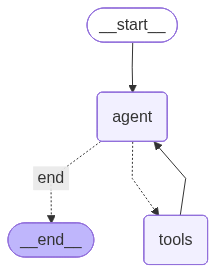

In [64]:
# Visualize the RAG agent
try:
    from IPython.display import display, Image
    display(Image(rag_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure:")
    print(rag_agent.get_graph().draw_ascii())

In [65]:
# Test the RAG agent
print("Testing Agentic RAG (with local models):")
print("=" * 50)

response = rag_agent.invoke({
    "messages": [HumanMessage(content="What are some tips for better sleep?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Agentic RAG (with local models):

Final Response:
Here are evidence-based tips to improve your sleep:

- Keep a consistent sleep schedule, even on weekends. Aim for the same bedtime and wake time daily [Source 2] [Source 3].
- Create a relaxing 30–60 minute wind-down routine (e.g., light reading, gentle stretching, or a warm bath) before bed [Source 2].
- Optimize your sleep environment: keep your bedroom cool (65–68°F / 18–20°C), dark (use blackout curtains or a sleep mask), and quiet (white noise or earplugs can help). Make sure your mattress and pillows are comfortable [Source 1] [Source 2] [Source 3].
- Limit screens at least 1 hour before bed; 1–2 hours is even better [Source 2] [Source 3].
- Watch your stimulants and meals: avoid caffeine after 2 PM; limit alcohol and heavy meals close to bedtime [Source 2] [Source 3].
- Exercise regularly, but try not to work out too close to bedtime [Source 2].
- Aim for 7–9 hours of sleep per night [Source 3].

If sleep problems persis

In [66]:
# Test with a complex query requiring both RAG and calculation
print("Testing with complex query:")
print("=" * 50)

response = rag_agent.invoke({
    "messages": [HumanMessage(
        content="I'm stressed and sleeping poorly. What should I do? Also, if I sleep 6 hours a night for a week, how many total hours is that?"
    )]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing with complex query:

Final Response:
I’m sorry you’re dealing with this—stress and poor sleep can feed into each other. Here’s a simple, evidence-based plan you can try.

For better sleep (start tonight):
- Keep a consistent sleep/wake time daily and add a 20–30 minute wind‑down (reading, gentle stretching, or a warm bath). (Knowledge base: Chapter 8 – Improving Sleep Quality)
- Make your bedroom cool, dark, and quiet; aim for 65–68°F, use blackout curtains/sleep mask, and consider white noise. (KB: Sleep Checklist; Chapter 8)
- Limit screens for 1–2 hours before bed; avoid caffeine after 2 PM; limit alcohol and heavy meals close to bedtime; exercise regularly but not too late. (KB: Chapter 8; Sleep Checklist)
- Adults generally need 7–9 hours per night. If you’re regularly short on sleep, gradually move your bedtime earlier by 15–20 minutes every few nights. (KB: Chapter 7 – The Science of Sleep)

To lower stress:
- Quick relief you can use anytime:
  - Box breathing: inhale 4

In [67]:
# Test that the agent knows when NOT to use RAG
print("Testing agent decision-making (should NOT use RAG):")
print("=" * 50)

response = rag_agent.invoke({
    "messages": [HumanMessage(content="What is 125 * 8?")]
})

print("\nFinal Response:")
print(response["messages"][-1].content)

Testing agent decision-making (should NOT use RAG):

Final Response:
125 * 8 = 1000


---
## ❓ Question #3:

Compare the experience of building an agent from scratch with LangGraph versus using `create_agent` from Session 3. What are the trade-offs between control and convenience? When would you choose one approach over the other?

##### Answer:
*Building agent from scratch **versus** 'create_agent' had the following pros and cons:
Pros:
1. Full control over the loop
2. Add as much logging and custom logging as needed.

Cons:
1. More coding involved and prone to making mistakes.
2. More time to build and test.

When I would choose which approach:
If I am building a security related tool where security is the major concern I would build the agent from scratch. If not if I am testing a quick POC, I think '*create_agent*' is besyt suited
*

## ❓ Question #4:

We used local models (gpt-oss:20b and embeddinggemma) instead of cloud APIs. What are the advantages and disadvantages of this approach? 

##### Answer:
*Advantages of using local models (gpt-oss:20b and embeddinggemma) instead of cloud APIs

1. Data Control and Privacy
2. Chepaer than Cloud APIs
3. Works offline

Best suited for a building a tool with sensitive/legal documents where external API calls can be very risky.

Disadvantages:
1. Latency issues: They are slower
2. Too buch burden on the local system resources since it runs on your computer.
3. Model Quality gap: Won't perform as good as the cloud models.*

---
## 🏗️ Activity #2: Extend the Agent with Memory

LangGraph supports **checkpointing** which enables conversation memory across invocations.

Your task: Add memory to the RAG agent so it can:
1. Remember previous questions in the conversation
2. Reference past context when answering new questions
3. Build on previous answers

Hint: Use `MemorySaver` from `langgraph.checkpoint.memory` and pass a `thread_id` in the config.

**📚 Documentation:**
- [LangGraph Persistence & Memory](https://langchain-ai.github.io/langgraph/concepts/persistence/)
- [How to add memory to your graph](https://langchain-ai.github.io/langgraph/how-tos/persistence/)
- [MemorySaver Reference](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver)

In [68]:
# ---- Imports (with a few safe fallbacks for different versions) ----
from typing import TypedDict, Annotated, List, Dict, Any, Optional

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph, END
try:
    from langgraph.graph import START
except Exception:
    # Older versions: you can also set entry point instead of START
    START = "__start__"

from langgraph.graph.message import add_messages

# MemorySaver import path can vary slightly by version
try:
    from langgraph.checkpoint.memory import MemorySaver
except Exception:
    from langgraph.checkpoint import MemorySaver


# =========================
# 1) Define State (messages accumulate + memory across invocations)
# =========================
class AgentState(TypedDict):
    # Annotated + add_messages tells LangGraph how to append new messages to history
    messages: Annotated[List[BaseMessage], add_messages]


# =========================
# 2) Define Tools (RAG-like KB search + calculator)
# =========================
class KBArgs(BaseModel):
    query: str = Field(..., description="Question to search in the wellness KB.")
    top_k: int = Field(3, description="How many snippets to return.")

@tool("search_wellness_knowledge", args_schema=KBArgs)
def search_wellness_knowledge(query: str, top_k: int = 3) -> Dict[str, Any]:
    """
    Search the wellness knowledge base and return evidence snippets.
    Use this when you need factual wellness guidance (progressive overload, deload, recovery).
    """
    kb = [
        {"id": "KB1", "title": "Deload Guidance", "text": "If fatigue stalls performance for ~2+ weeks, reduce volume by ~30–50% for 1 week (deload)."},
        {"id": "KB2", "title": "Progressive Overload", "text": "Add small load (2–5%) or 1 rep weekly while keeping 1–3 reps in reserve (RIR). Increase load after topping rep range."},
        {"id": "KB3", "title": "Recovery Basics", "text": "Sleep and hydration strongly influence recovery, performance, and muscle gain."},
    ]
    q = query.lower()
    scored = []
    for item in kb:
        score = sum(1 for w in q.split() if w in item["title"].lower() or w in item["text"].lower())
        scored.append((score, item))
    scored.sort(key=lambda x: x[0], reverse=True)
    hits = [item for s, item in scored[:top_k] if s > 0] or [scored[0][1]]
    return {"query": query, "results": hits}

class CalcArgs(BaseModel):
    expression: str = Field(..., description="Math expression like '19*23'.")

@tool("calculate", args_schema=CalcArgs)
def calculate(expression: str) -> Dict[str, Any]:
    """
    Evaluate a simple math expression.
    Use this when the user asks for arithmetic.
    """
    allowed = set("0123456789+-*/(). %")
    if any(ch not in allowed for ch in expression):
        raise ValueError("Expression contains unsupported characters.")
    result = eval(expression, {"__builtins__": {}}, {})
    return {"expression": expression, "result": result}

TOOLS = [search_wellness_knowledge, calculate]
TOOL_BY_NAME = {t.name: t for t in TOOLS}


# =========================
# 3) LLM (tool-calling enabled)
# =========================
# Use a tool-capable model you have access to. You can swap "gpt-4.1-mini" -> "gpt-5" if enabled.
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0).bind_tools(TOOLS)


# =========================
# 4) Nodes
# =========================
def agent_node(state: AgentState) -> AgentState:
    """Call the model with the full conversation history."""
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

def tool_node(state: AgentState) -> AgentState:
    """
    Execute tools for the most recent AI message that contains tool_calls.
    IMPORTANT: If AI emitted tool_calls, the very next messages MUST be ToolMessages
    for each tool_call_id (OpenAI tool-calling protocol).
    """
    # Find latest message with tool_calls (usually the last AI message)
    tool_calls = []
    for msg in reversed(state["messages"]):
        tc = getattr(msg, "tool_calls", None) or []
        if tc:
            tool_calls = tc
            break

    if not tool_calls:
        return {"messages": []}

    tool_messages: List[ToolMessage] = []

    for tc in tool_calls:
        tool_name = tc.get("name")
        tool_args = tc.get("args", {}) or {}
        tool_id = tc.get("id")

        try:
            if tool_name not in TOOL_BY_NAME:
                raise ValueError(f"Unknown tool: {tool_name}")

            output = TOOL_BY_NAME[tool_name].invoke(tool_args)
            tool_messages.append(ToolMessage(content=str(output), tool_call_id=tool_id))
        except Exception as e:
            tool_messages.append(ToolMessage(content=f"Tool '{tool_name}' error: {type(e).__name__}: {e}", tool_call_id=tool_id))

    return {"messages": tool_messages}


# =========================
# 5) Routing logic (continue if tool_calls exist)
# (No AgentState type annotation here to avoid notebook schema mismatch issues.)
# =========================
def should_continue(state):
    last = state["messages"][-1]
    tool_calls = getattr(last, "tool_calls", None) or []
    return "tools" if tool_calls else "end"


# =========================
# 6) Build + compile graph with MemorySaver (checkpointing)
# =========================
workflow = StateGraph(AgentState)
workflow.add_node("agent", agent_node)
workflow.add_node("tools", tool_node)

# Entry point
try:
    workflow.add_edge(START, "agent")
except Exception:
    workflow.set_entry_point("agent")

# Conditional loop
workflow.add_conditional_edges("agent", should_continue, {"tools": "tools", "end": END})
workflow.add_edge("tools", "agent")

checkpointer = MemorySaver()
rag_agent = workflow.compile(checkpointer=checkpointer)

print("✅ Graph compiled with MemorySaver (conversation memory enabled)")


# =========================
# 7) Helper: run a turn with a thread_id (same thread_id == same memory)
# =========================
def chat(thread_id: str, user_text: str) -> str:
    out = rag_agent.invoke(
        {"messages": [HumanMessage(content=user_text)]},
        config={"configurable": {"thread_id": thread_id}},
    )
    # last AI message content
    for msg in reversed(out["messages"]):
        if isinstance(msg, AIMessage) and msg.content:
            return msg.content
    return "(No assistant message found.)"


# =========================
# 8) Demo: memory across invocations
# =========================
THREAD = "wellness_demo_thread_1"

print("\n--- Turn 1 ---")
print(chat(THREAD, "What is progressive overload? Use the wellness KB and cite your source ids."))

print("\n--- Turn 2 (references past context) ---")
print(chat(THREAD, "Based on that, give me a simple weekly progression example."))

print("\n--- Turn 3 (builds on previous answers) ---")
print(chat(THREAD, "If I stall for 2 weeks, what should I change? Again cite KB sources."))

✅ Graph compiled with MemorySaver (conversation memory enabled)

--- Turn 1 ---
Progressive overload is the practice of adding a small load (2–5%) or 1 rep weekly while keeping 1–3 reps in reserve (RIR). The load is increased after topping the rep range. This method helps in gradually increasing the intensity of workouts to promote strength and muscle gains. (Source: KB2)

--- Turn 2 (references past context) ---
Sure! Here's a simple weekly progression example based on progressive overload:

Week 1: Lift a weight for 8 reps with 2 reps in reserve (RIR).
Week 2: Add a small load increase of about 2-5% or try to do 9 reps with the same weight, keeping 1-3 reps in reserve.
Week 3: Add another small load increase of 2-5% or aim for 10 reps, still keeping 1-3 reps in reserve.
Week 4: Once you reach the top of your rep range (e.g., 10 reps), increase the load again by 2-5% and drop back to 8 reps with 1-3 reps in reserve.

This gradual increase in load or reps while maintaining some reps in

---
## Summary

In this session, we:

1. **Built agents from scratch** using LangGraph's low-level primitives (StateGraph, nodes, edges)
2. **Used local open-source models** with Ollama (gpt-oss:20b + embeddinggemma)
3. **Transitioned to LangChain** for document loading and text splitting
4. **Created an Agentic RAG system** that intelligently decides when to retrieve information

### Key Takeaways:

- **StateGraph** gives you full control over agent architecture
- **Conditional edges** enable dynamic routing based on LLM decisions
- **Local models** provide privacy and cost savings, with trade-offs in performance
- **LangSmith** provides crucial visibility regardless of where your models run

### What's Next?

Now that you understand the fundamentals, you can:
- Add more sophisticated routing logic
- Implement human-in-the-loop patterns
- Build multi-agent systems
- Deploy to production with LangGraph Platform

**📚 Further Reading:**
- [LangGraph How-To Guides](https://langchain-ai.github.io/langgraph/how-tos/)
- [Human-in-the-Loop Patterns](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/)
- [Multi-Agent Architectures](https://langchain-ai.github.io/langgraph/concepts/multi_agent/)
- [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/)